# Create a SBML Model With BioCRNpyler

In [2]:
from biocrnpyler import *
from vivarium.core.engine import pp

# TX/TL module

## Use [BioCRNpyler](https://github.com/BuildACell/BioCRNPyler) to make a Chemical Reaction Network (CRN)

An unrealistically simple model of transcription from a gene $G$ to a transcript $T$ to a protein $P$

## $G \to G + T$
## $T \to T + P$

In [3]:
G = Species("G")
T = Species("T")
P = Species("P")

ktx = 1.0
ktl = 1.0
txrxn = Reaction.from_massaction(inputs = [G], outputs = [G, T], k_forward=ktx)
tlrxn = Reaction.from_massaction(inputs = [T], outputs = [T, P], k_forward=ktl)

CRN = ChemicalReactionNetwork(
    species = [G, T, P], 
    reactions = [txrxn, tlrxn],
    initial_concentration_dict = {G:1, T:0, P:0})

print(CRN.pretty_print(show_compartment = True))

CRN.write_sbml_file("txtl.xml")

Species(N = 3) = {
G (@ 1),  T (@ 0),  P (@ 0),  
}

Reactions (2) = [
0. G --> G+T
 Kf=k_forward * G
  k_forward=1.0

1. T --> T+P
 Kf=k_forward * T
  k_forward=1.0

]


True

## Load the CRN into [Vivarium-Bioscrape](https://github.com/vivarium-collective/vivarium-bioscrape)

[Vivarium](https://academic.oup.com/bioinformatics/advance-article-abstract/doi/10.1093/bioinformatics/btac049/6522109?redirectedFrom=fulltext) is a multiscale-multimodal simulation engine with [many supported simulators](https://github.com/orgs/vivarium-collective/repositories?type=all). [Bioscrape](https://github.com/biocircuits/bioscrape) is a CRN simulator which can load the SBML files produced by BioCRNpyler. Vivarium-Bioscrape is Vivarium wrapper around Bioscrape.

In [4]:
from vivarium.core import store
from vivarium_bioscrape.processes.bioscrape import Bioscrape

txtl_parameters = {
    "sbml_file":"txtl.xml",
    "timestep": 1.0
}

#Create a Store
S = store.Store({})
bioscrape_process = Bioscrape(txtl_parameters)
S["txtl"] = bioscrape_process
S.set_value(bioscrape_process.initial_state())
print(pp(S.get_value()))

{ 'delta_species': {'G': 0.0, 'P': 0.0, 'T': 0.0},
  'globals': {'volume': 1.0},
  'rates': {'k_forward': 1.0, 'k_forward_r1': 1.0},
  'species': {'G': 1.0, 'P': 0.0, 'T': 0.0},
  'txtl': ( <vivarium_bioscrape.processes.bioscrape.Bioscrape object at 0x000001B8FDEA8CC8>,
            { 'delta_species': ('delta_species',),
              'globals': ('globals',),
              'rates': ('rates',),
              'species': ('species',)})}
None


## Plot the topology

In [5]:
from vivarium.core.composer import Composite
from vivarium.plots.topology import plot_topology

composite = Composite(store=S)
fig = plot_topology(composite)

## Run the Vivarium-Bioscrape TXTL process alone then plot the results

In [6]:
%matplotlib inline
from vivarium.core.engine import Engine

# put the store in an engine and run it
sim = Engine(store=S)
steps = 100
sim.update(steps)


Simulation ID: ad7ac8ae-9e47-11ec-9453-6c2b5976b3a5
Created: 03/07/2022 at 10:52:03
Completed in 0.021941 seconds


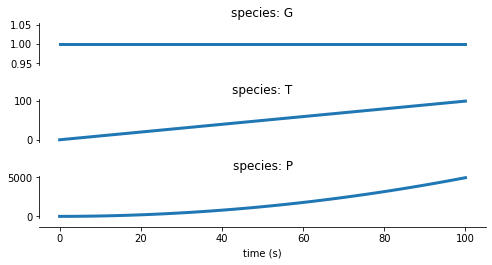

In [7]:
from vivarium.plots.simulation_output import plot_variables

# get the data
data = sim.emitter.get_timeseries()
#Plot the data
fig = plot_variables(data, variables=[
    ('species', 'G'),
    ('species', 'T'),
    ('species', 'P')])

# A Second Transcription Process

### $RNAP + G \rightleftharpoons RNAP:G \to RNAP + G + T$

Species(N = 4) = {
RNAP (@ 10),  G (@ 1),  T (@ 0),  complex[G:RNAP] (@ 0),  
}

Reactions (2) = [
0. G+RNAP <--> complex[G:RNAP]
 Kf=k_forward * G * RNAP
 Kr=k_reverse * complex_G_RNAP_
  k_forward=100.0
  k_reverse=1.0

1. complex[G:RNAP] --> G+RNAP+T
 Kf=k_forward * complex_G_RNAP_
  k_forward=1.0

]
{ 'delta_species': {'G': 0.0, 'RNAP': 0.0, 'T': 0.0, 'complex_G_RNAP_': 0.0},
  'globals': {'volume': 1.0},
  'rates': {'kb__': 100.0, 'ktx__': 1.0, 'ku__': 1.0},
  'species': {'G': 1.0, 'RNAP': 10.0, 'T': 0.0, 'complex_G_RNAP_': 0.0},
  'tx': ( <vivarium_bioscrape.processes.bioscrape.Bioscrape object at 0x000001B88706BE08>,
          { 'delta_species': ('delta_species',),
            'globals': ('globals',),
            'rates': ('rates',),
            'species': ('species',)})}
None

Simulation ID: bb587070-9e49-11ec-add9-6c2b5976b3a5
Created: 03/07/2022 at 11:06:45
Completed in 0.021941 seconds


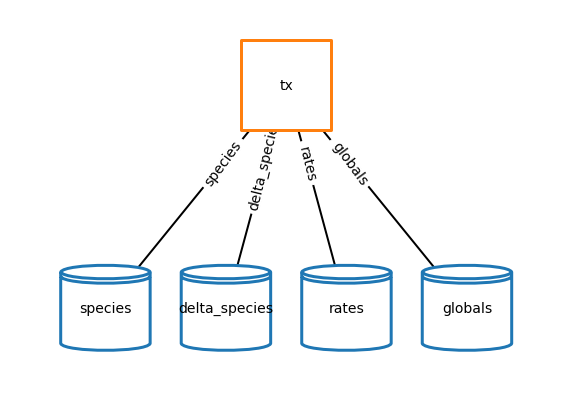

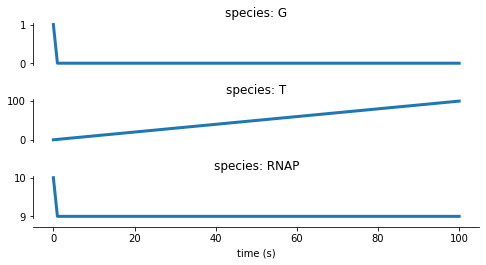

In [25]:
#Create a CRN
G = Species("G")
RNAP = Species("RNAP")
G_RNAP = Complex([G, RNAP])
T = Species("T")

ktx = ParameterEntry(parameter_name = "ktx", parameter_value = 1.0)
kb = ParameterEntry(parameter_name = "kb", parameter_value = 100.0)
ku = ParameterEntry(parameter_name = "ku", parameter_value = 1.0)

r1 = Reaction.from_massaction(inputs=[G, RNAP], outputs = [G_RNAP], k_forward = kb, k_reverse = ku)
r2 = Reaction.from_massaction(inputs = [G_RNAP], outputs = [G, RNAP, T], k_forward = ktx)

CRN2 = ChemicalReactionNetwork(
    species = [G, RNAP, G_RNAP, T], 
    reactions = [r1, r2],
    initial_concentration_dict = {G:1, T:0, RNAP:10})

print(CRN2.pretty_print(show_compartment = True))

#Save the CRN
CRN2.write_sbml_file("tx.xml")

#Load into Vivarium-Bioscrape
tx_parameters = {
    "sbml_file":"tx.xml",
    "timestep": 1.0
}

#Create a Store
S = store.Store({})
bioscrape_process = Bioscrape(tx_parameters)
S["tx"] = bioscrape_process
S.set_value(bioscrape_process.initial_state())
print(pp(S.get_value()))

#Plot Topology
composite = Composite(store=S)
fig = plot_topology(composite)

#Simulate
sim = Engine(store=S)
steps = 100
sim.update(steps)

# get the data
data = sim.emitter.get_timeseries()
#Plot the data
fig = plot_variables(data, variables=[
    ('species', 'G'),
    ('species', 'T'),
    ('species', 'RNAP')])

# Create a Custom Vivarium Process to Model Transcription Rate Dependence on the Amounts of Various Chemicals Using Hill Functions

In [48]:
from vivarium.core.process import Process
import numpy as np


class TxRate(Process):

    defaults = {
        'K': 5,
        'n': 2,
    }

    def __init__(self, parameters=None):
        super().__init__(parameters)

    def ports_schema(self):
        return {
            'rates': {
                '*': {
                    '_default': 0.0,
                    '_emit': True,
                    '_updater': 'set'
                }
            },
            'species': {
                "*": {
                '_default': 0.0,
                '_emit': True,
                }
            }
        }

    def next_update(self, timestep, states):
        ktx = states['rates']['ktx__']
        T = states['species']['T']
        K = self.parameters["K"]
        n = self.parameters["n"]
        
        
        new_ktx = ktx/(1 + (T/K)**n)
        
        
        return { 
            'rates':{
                "ktx__":new_ktx
            }
        }

{ 'delta_species': {'G': 0.0, 'RNAP': 0.0, 'T': 0.0, 'complex_G_RNAP_': 0.0},
  'globals': {'volume': 1.0},
  'rates': {'kb__': 100.0, 'ktx__': 1.0, 'ku__': 1.0},
  'species': {'G': 1.0, 'RNAP': 10.0, 'T': 0.0, 'complex_G_RNAP_': 0.0},
  'tx_process': ( <vivarium_bioscrape.processes.bioscrape.Bioscrape object at 0x000001B887273348>,
                  { 'delta_species': ('delta_species',),
                    'globals': ('globals',),
                    'rates': ('rates',),
                    'species': ('species',)}),
  'txrate_process': ( <__main__.TxRate object at 0x000001B887284448>,
                      {'rates': ('rates',), 'species': ('species',)})}
None

Simulation ID: c03afb40-9e4b-11ec-9200-6c2b5976b3a5
Created: 03/07/2022 at 11:21:12
Completed in 0.030602 seconds


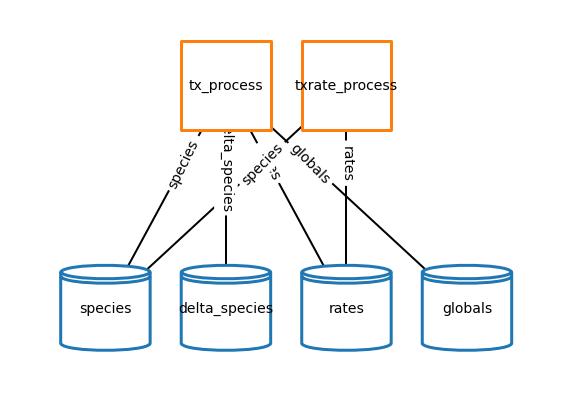

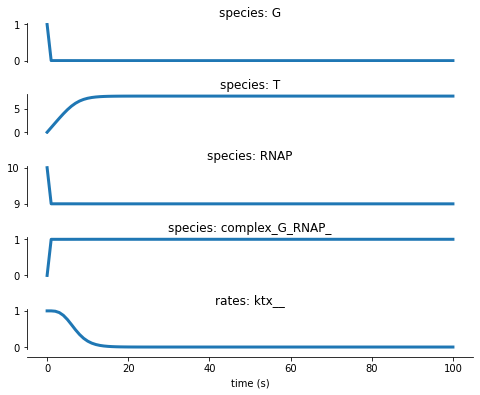

In [54]:
#Create a Store
S = store.Store({})

# make bioscrape
txtl_parameters = {
    "sbml_file":"tx.xml",
    "timestep": 1.0
}
tx_process = Bioscrape(tx_parameters)
S["tx_process"] = tx_process
tx_initial = tx_process.initial_state()
S.set_value(tx_initial)

# get the rates for bioscrape_process
rates = {'ktx': 1.0}
txrate_process = TxRate({
    'K': 10.,
    'n': 2.,
    'rates':rates
})
S["txrate_process"] = txrate_process


print(pp(S.get_value()))

composite = Composite(store=S)
fig = plot_topology(composite)

# put the store in an engine and run it
sim = Engine(store=S)
steps = 100
sim.update(steps)

data = sim.emitter.get_timeseries()
fig = plot_variables(data, variables=[
    ('species', 'G'),
    ('species', 'T'),
    ('species', 'RNAP'),
    ('species', str(G_RNAP)),
    ('rates', 'ktx__')
#     ('salt',),
])

# Adding more complexity via a custom Vivarium `Process`

In the following example, we model how salt concentration may effect chemical reaction rates. This model is a heuristic we invented as an example. It assmumes that salt concentrations causes a super-exponential drop in expression (modeled by a Guassian) as it deviates from the optimal value.

### All Vivarium `Processes`Require: 
* a `ports_schema` which defines the variables names passed into `Process.next_update`as a `state` dictionary
* a set of `default` used for internal parameter values (these can be updated via the `parameters` in the constructor
* a `next_update` function which takes a state and updates it


In [7]:
from vivarium.core.process import Process
import numpy as np

def gaussian(x, mean, variance):
    return np.exp(-(x - mean) ** 2 / variance)

class Salt(Process):

    defaults = {
        'mean': 5, # (Mg) this is the salt concentration for max activity
        'variance': 2,
        'max_rates': {},
    }

    def __init__(self, parameters=None):
        super().__init__(parameters)

    def ports_schema(self):
        return {
            'rates': {
                '*': {
                    '_default': 0.0,
                    '_emit': True,
                    '_updater': 'set'
                }
            },
            'salt': {
                '_default': 0.0,
                '_emit': True,
            }
        }

    def next_update(self, timestep, states):
        salt = states['salt']
        
        activity = gaussian(
            salt, self.parameters['mean'], self.parameters['variance'])
        
        return {
            'rates': {
                param_id: max_rate*activity 
                for param_id, max_rate in self.parameters['rates'].items()}
        }

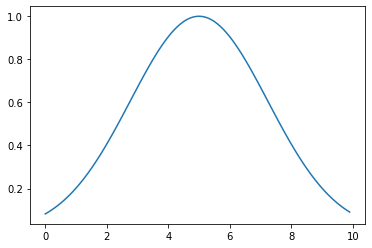

In [8]:
import pylab as plt

plt.plot(np.arange(0,10,0.1), [gaussian(x, mean=5, variance=10) for x in np.arange(0,10,0.1)])

# Wiring `Processes` Together with `Stores`

`Stores` are the Vivarium objects which hold the state variables that are accesssed by different processes. By sharing variables in a `Store`, different `Processes` can be coupled together during simulation. To do this, each `Process` is places inside a `Store`. Because the port_schema of the Bioscrape and Salt Processes both contain variables called `rates`, these will automatically be shared between the processes. 

In [9]:
#Create a Store
S2 = store.Store({})

# make bioscrape
txtl_parameters = {
    "sbml_file":"txtl.xml",
    "timestep": 1.0
}
txtl_process = Bioscrape(txtl_parameters)
S2["txtl_process"] = bioscrape_process
txtl_initial = txtl_process.initial_state()
S2.set_value(txtl_initial)

# get the rates for bioscrape_process
rates = {'k_forward': 1.0, 'k_forward_r1': 1.0}
salt_process = Salt({
    'mean': 5.,
    'variance': 1.,
    'rates': rates,
})
S2["salt_process"] = salt_process
S2["salt"] = 4.

print(pp(S2.get_value()))

{ 'delta_species': {'G': 0.0, 'P': 0.0, 'T': 0.0},
  'globals': {'volume': 1.0},
  'rates': {'k_forward': 1.0, 'k_forward_r1': 1.0},
  'salt': 4.0,
  'salt_process': ( <__main__.Salt object at 0x12ee817c0>,
                    {'rates': ('rates',), 'salt': ('salt',)}),
  'species': {'G': 1.0, 'P': 0.0, 'T': 0.0},
  'txtl_process': ( <vivarium_bioscrape.processes.bioscrape.Bioscrape object at 0x11f59ddc0>,
                    { 'delta_species': ('delta_species',),
                      'globals': ('globals',),
                      'rates': ('rates',),
                      'species': ('species',)})}
None


## Plot the topology

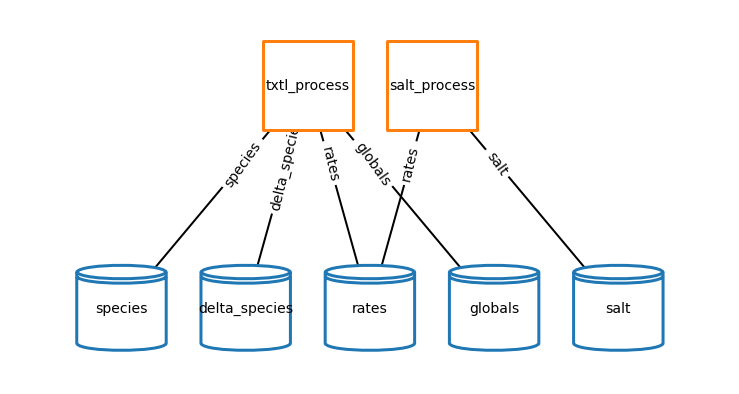

In [14]:
from vivarium.core.composer import Composite
from vivarium.plots.topology import plot_topology

composite = Composite(store=S2)
fig = plot_topology(composite)

# Simulate the 2-Process Model

In [10]:
%matplotlib inline
from vivarium.core.engine import Engine

# put the store in an engine and run it
sim2 = Engine(store=S2)
steps = 100
sim2.update(steps)


Simulation ID: ebfec414-9ca2-11ec-bc97-8c85908ac627
Created: 03/05/2022 at 08:40:09
Completed in 0.030456 seconds


## Vary the salt concentration


Simulation ID: ec04893a-9ca2-11ec-bc97-8c85908ac627
Created: 03/05/2022 at 08:40:09
Completed in 0.031908 seconds


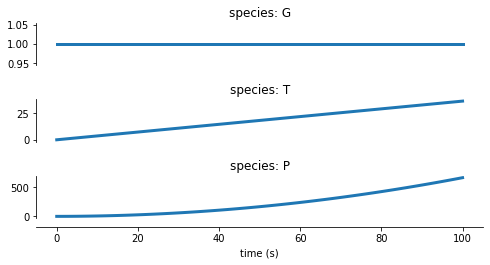

In [11]:
# put the store in an engine and run it
S2.set_value(txtl_initial)
S2["salt"] = 4.
sim2 = Engine(store=S2)
steps = 100
sim2.update(steps)

# get the data
data = sim2.emitter.get_timeseries()
fig = plot_variables(data, variables=[
    ('species', 'G'),
    ('species', 'T'),
    ('species', 'P'),
#     ('salt',),
])


Simulation ID: ec3343c4-9ca2-11ec-bc97-8c85908ac627
Created: 03/05/2022 at 08:40:10
Completed in 0.026990 seconds


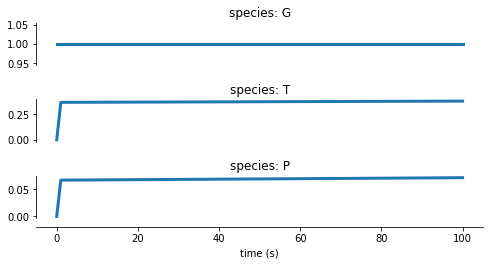

In [12]:
# put the store in an engine and run it
S2.set_value(txtl_initial)
S2["salt"] = 2
sim2 = Engine(store=S2)
steps = 100
sim2.update(steps)

# get the data
data = sim2.emitter.get_timeseries()
fig = plot_variables(data, variables=[
    ('species', 'G'),
    ('species', 'T'),
    ('species', 'P'),
#     ('salt',),
])